In [1]:
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
import datetime 
from datetime import datetime 
import numpy as np

# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
#from neurone.runners.extended import HeatmapExtendedDetectionRunner
from neurone.runners.gridsearch import GridSearchRunner

E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}

#args.engine = "cpu"
#args.tracker = "tensorboard"

print('Get current working directory : ', os.getcwd())
config_path = "./configs/detection.json"
!cat ./configs/detection.json
with open(config_path, "r") as config_file:
        config = json.load(config_file)
        
        
config["data"]["split_info"] = "/home/data-histology/endonuke_data/trainval/split_info.yml"
config["train"]["experiment_name"] = config["train"]["save_dir"] + " " + config["train"]["experiment_name"]  + " " + str(datetime.now())
#whether to overwrite the model or not
#config["train"]["verbose"] = True
#config["train"]["overwrite"] = True
config["train"]["deterministic"] = False
config["train"]["seed"] = 42
config["train"]["checkpoints_dir"] = "checkpoints"
config["train"]["logging_dir"] = "logs"
config['train']['tracker'] = "tensorboard"
config["train"]["engine"] = "cpu"
if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E["cpu"](
    log_with="tensorboard", logging_dir=logging_dir), config=config)


Get current working directory :  /home/alexmak123/neurone
{
  "model": {
    "runner": "HeatmapDetectionRunner",
    "model_name": "HeatmapDetector",
    "model_kwargs": {
      "backbone": "Unet",
      "encoder_name": "resnet34",
      "encoder_depth": 5,
      "encoder_weights": "imagenet",
      "in_channels": 3,
      "classes": 2,
      "activation": null,
      "min_peak_value": 0.245,
      "pooling_scale": 7,
      "out_image_shape": [
        512,
        512
      ],
      "supression_range": 3.099
    },
    "weigths_path": "/home/alexmak123/neurone/experiments/experiment_2022-10-27 19:25:38.336325/model.pth",
    "class_separator": null,
    "class_labels_map": {
      "0": 0,
      "1": 1,
      "2": 0
    },
    "input_shape": [
      512,
      512
    ]
  },
  "data": {
    "split_info": null,
    "dataset_dir": "/home/data-histology/endonuke_data/trainval",
    "save_console_logs": true,
    "workers": 2,
    "heatmaps_sigma": 7.62,
    "norm_mean": [
      213,
     

In [2]:
# Specify Model
runner._setup_model()
runner.model.eval()

HeatmapDetector(
  (heatmap_model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

### Right now we should define what color we call brown in our cells

We will use the next approach to define which color is brown. Lets take 5 cells that are confirmed that they are plasmatic and after that we will apply mathematical statistics to count the average (h s v) of brown cells plus the error

here are 5 cells that are plasmatic : 


/home/alexmak123/yesno/yes
'yes1.png?raw=true'  'yes3.png?raw=true'  'yes5.png?raw=true'
'yes2.png?raw=true'  'yes4.png?raw=true'
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(5, 512, 512, 3)
/home/alexmak123/yesno


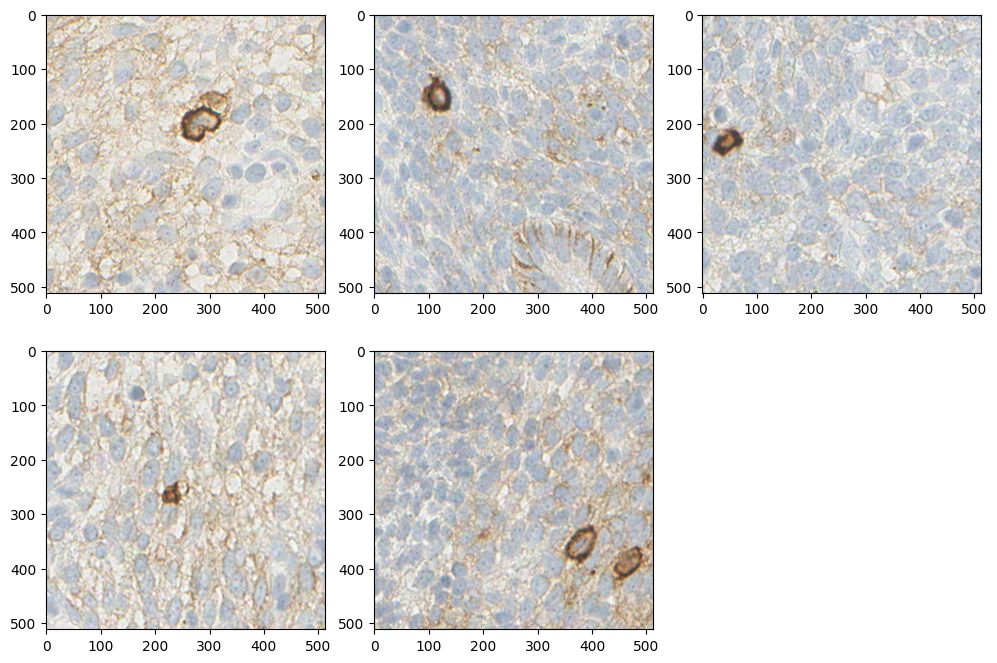

In [3]:
#some transformations for propper data fromat
import matplotlib.pyplot as plt
import albumentations as A
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])

#Download our tile
%cd ../yesno/yes
%ls 
directory_in_str = "/home/alexmak123/yesno/yes"

import cv2
from PIL import Image

def import_tiles_from_directory_and_convert_them (directory_in_str):
    directory = os.fsencode(directory_in_str)
    converted_images = []
    i = 1
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("?raw=true"): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            print (myTile.shape)
            plt.subplot(3, 3, i)
            plt.imshow(myTile)
            converted_images.append(myTile)
            i += 1
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (directory_in_str)
print (converted_images.shape)
%cd ..

In [4]:
import sys


#our data to tensor
image_torch = torch.tensor(converted_images)
print (image_torch.shape)
#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()

#here should be meanstd values, counted for this picture, but with counted meanstd it doesn't classify properly on stroma and epithelium. That's why we use standard meanstd values
#!!!NOTE: ASK ABOUT THIS!!!

#meanstd counted for the slide, from where we have taken our tiles
config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2] = (198, 195, 190)
config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2] = (25, 24, 25)

image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)
    

#np.set_printoptions(threshold=sys.maxsize)
print ("Keypoints of all tiles : \n")
keypoints = runner.model(image_torch)["keypoints"]
print (keypoints, "\n")
print ("Confidences of all tiles : \n")
confidences = runner.model(image_torch)["confidences"]
print (confidences, "\n")

#x_coords = keypoints.x_coords()
#y_coords = keypoints.y_coords()
#classes = keypoints.classes()

torch.Size([5, 512, 512, 3])
Keypoints of all tiles : 

[[  0. 143. 483.   0.]
 [  0. 337. 340.   0.]
 [  0.  81. 486.   0.]
 ...
 [  4. 208. 196.   0.]
 [  4. 195. 125.   0.]
 [  4. 480. 313.   0.]] 

Confidences of all tiles : 

[5.18661086e-03 8.11921805e-03 1.12528047e-02 1.79900639e-02
 3.90649624e-02 3.93570252e-02 8.63415897e-02 9.90673825e-02
 1.14867903e-01 1.50471494e-01 1.58379599e-01 2.11278960e-01
 2.43518054e-01 2.52127022e-01 2.61447996e-01 2.71976531e-01
 2.96725184e-01 3.06109667e-01 3.39666724e-01 3.46785426e-01
 4.31562424e-01 4.94985402e-01 5.03190517e-01 5.07297158e-01
 5.90455115e-01 6.02720082e-01 6.30830824e-01 6.94559574e-01
 7.42834866e-01 5.44060138e-04 2.38771853e-03 4.61665587e-03
 8.68609361e-03 1.47679783e-02 1.48749109e-02 2.14804094e-02
 2.59886514e-02 2.62174383e-02 2.92703416e-02 3.48657183e-02
 3.82742733e-02 4.56080921e-02 5.14513999e-02 6.65155873e-02
 6.89235330e-02 7.19737932e-02 7.28679001e-02 7.46074468e-02
 7.97525123e-02 8.36242884e-02 8.3898

In [5]:
#split keypoints of all the tiles to an array of selected colums with x_coords, y_coords and classes of all tiles
#later we would not need this, but for demonstration that everything works properly we will use these "split tiles"
j = 0
selected_columns_array = []
for index_tile in range(converted_images.shape[0]):
    selected_columns = []
    while (j < keypoints.shape[0] and keypoints[j][0] == index_tile):
        selected_columns.append([keypoints[j][1], keypoints[j][2], keypoints[j][3]])
        j += 1
    selected_columns_array.append(np.array(selected_columns))
    
print (np.array(selected_columns_array, dtype=object))

[array([[143., 483.,   0.],
        [337., 340.,   0.],
        [ 81., 486.,   0.],
        [348., 286.,   0.],
        [385., 289.,   0.],
        [435., 162.,   0.],
        [349., 464.,   0.],
        [491., 208.,   0.],
        [426., 279.,   0.],
        [285., 195.,   0.],
        [267., 441.,   0.],
        [ 75., 256.,   0.],
        [357., 180.,   0.],
        [487., 256.,   0.],
        [142.,  28.,   0.],
        [283., 174.,   0.],
        [276., 223.,   0.],
        [261., 184.,   0.],
        [387., 199.,   0.],
        [298., 178.,   0.],
        [492., 296.,   0.],
        [ 17., 187.,   0.],
        [382., 242.,   0.],
        [312., 202.,   0.],
        [187.,   4.,   0.],
        [473.,  29.,   0.],
        [460., 233.,   0.],
        [387., 477.,   0.],
        [  5., 490.,   0.]]) array([[ 55.,  22.,   0.],
                                    [ 23., 475.,   0.],
                                    [456.,  46.,   0.],
                                    [339.,  46.,

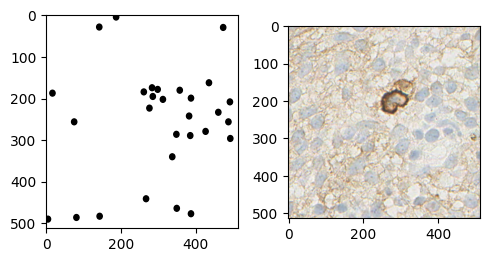

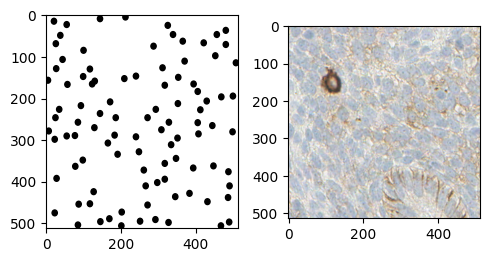

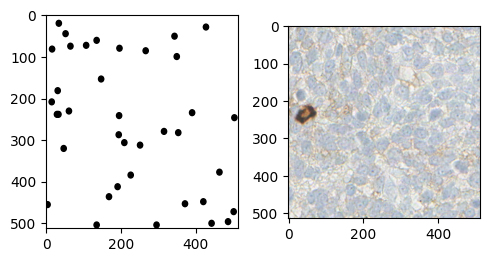

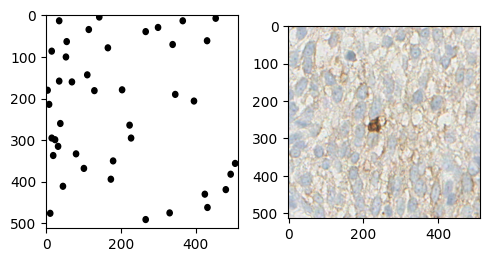

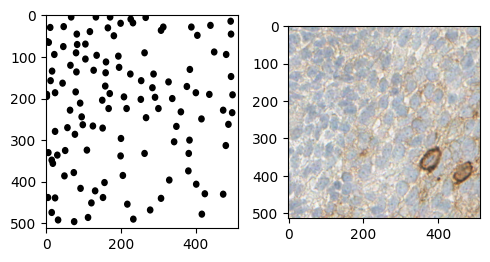

In [6]:
#make pictures
#Set the figure size
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True


for index_tile in range(converted_images.shape[0]):
    plt.subplot(2, 2, 1)
    #with circles
    ax = plt.gca()
    ax.cla()
    ax.set_xlim((0, 512))
    ax.set_ylim((0, 512))
    ax.invert_yaxis()
    circles_type={"radius": 7, "alpha": 1.0,  "linewidth": 1, 'ec': (0,0,0)}
    colormap = np.array(['k', 'b'])
    for dot_center in selected_columns_array[index_tile]:
        patch = plt.Circle((dot_center[0], dot_center[1]), color=colormap[dot_center[2].astype(int)], **circles_type)
        ax.add_patch(patch)


    plt.subplot(2, 2, 2)
    plt.imshow(converted_images[index_tile])
    plt.show()

In [7]:
#right now we will count the color of our stromas (cutting out the center) (stromas are on the left picture above and they are colored in black)
#note : first we get rgb colors and then we should convert them to hsv (to get rid of the Blue part, so that we can define brown)
#in this function we have selected_colums, which are our keypoints; cell_size which is a size of our sell; and cut_center_size which is a size of a square that we are cutting from our original cell
import math

def pixel_values_of_the_toruses(selected_columns, myTile, cell_size, cut_center_size = 0):
    if (cut_center_size > cell_size):
        raise ValueError("your cut_center_size is more than a cell_size")
    
    list_of_cells = []
    for dot_center in selected_columns:
        #we want only stromas
        if (dot_center[2] == 0): 
            x = dot_center[0]
            y = dot_center[1]
        
            #here we count max bounds of i and j for cell size and cut_center_size
        
            #!!!
            max_bound_for_cell = cell_size//2 
            max_bound_for_cut_center = cut_center_size//2
            #!!!
        
            i, j = -max_bound_for_cell, -max_bound_for_cell
            myCell = []
            #print ("new pair " + str(cell_size) + "x" + str(cell_size) + " : \n")
            while (x+i >= 0 and x+i < 512 and i <= max_bound_for_cell):
                j = -max_bound_for_cell
                while (y+j >= 0 and y+j < 512 and j <= max_bound_for_cell):
                    if (i >= -max_bound_for_cut_center and i <= max_bound_for_cut_center and j >= -max_bound_for_cut_center and j <= max_bound_for_cut_center):
                        j += 1
                        continue
                    #print(i, j)
                    #print(myTile[x+i][y+j])
                    myCell.append(myTile[x+i][y+j])
                    j += 1
                i += 1
                
            #print(np.array(myCell))
            if(cut_center_size == 0):
                myCell.append(myTile[x][y])
            if (len(myCell) != 0):
                list_of_cells.append(myCell)
            
    return np.array(list_of_cells)

So here are coordinates of plasmatic cells confirmed by the doctor (they are stored all in one array for all 5 tiles) :

In [8]:
brown_in_pics = [[(285, 195, 0)], [(130, 158, 0), (123, 165, 0)], [(29, 238, 0), (33, 238, 0)], [(223, 264, 0)], [(381, 332, 0)]]
print(brown_in_pics)

[[(285, 195, 0)], [(130, 158, 0), (123, 165, 0)], [(29, 238, 0), (33, 238, 0)], [(223, 264, 0)], [(381, 332, 0)]]


Let's define two masks (cell_size, cut_center_size) : for sells that are type Tile3,4 and for sells that are type Tile1,2,5


We will apply next approach : we will try many different masks in the range of 70 pixel for both cell_size and cut_center_size. If the mask detects this torus as brown colored (10 <= hue <= 20), then we will add this mask to result_mask_array for this type of Tile and for the most big sequence we will count mean as a mask for this type

In [9]:
#now lets count the mean color in RGB for each tile and each torus of the stroma in this tile; convert mean rgb values to hsv and take only tors that have brown color
import colorsys

def count_brown_tors_for_each_tile (tors_pixel_values):
    #list_of_brown_tors = []
    hsv_values_of_brown_tors = []
    for elem in tors_pixel_values:
        rgb_mean = np.mean(elem, axis = 0)
        (rgb_mean[0], rgb_mean[1], rgb_mean[2]) = (rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
        hsv = colorsys.rgb_to_hsv(rgb_mean[0], rgb_mean[1], rgb_mean[2])
        hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
        #if hue is >= 10 and <= 20 then we have a brown spectre color
        if (hsv[0] >= 10 and hsv[0] <= 20):
            #print(hsv)
            hsv_values_of_brown_tors.append(hsv)
            #list_of_brown_tors.append(elem)
    return (np.array(hsv_values_of_brown_tors))


In [43]:
#lets define cell_size and cut_center_size for two masks
#def definition_of_masks ()
result_mask_array_type_1 = []
result_mask_array_type_2 = []
arr = []
(i, j) = (1,1)
while (i <= 70):
    j = 1
    while (j <= i-2):
        for index_tile in range(converted_images.shape[0]):
            curr_tor = pixel_values_of_the_toruses(brown_in_pics[index_tile], converted_images[index_tile], i, j)
            #check if the current tor is brown 
            result_brown_tors = count_brown_tors_for_each_tile(curr_tor)
            arr.append([index_tile, i, j, result_brown_tors])
        j += 2
    i += 2

print (np.array(arr, dtype = object))

[[0 3 1 array([], dtype=float64)]
 [1 3 1 array([], dtype=float64)]
 [2 3 1 array([], dtype=float64)]
 [3 3 1 array([], dtype=float64)]
 [4 3 1 array([], dtype=float64)]
 [0 5 1 array([], dtype=float64)]
 [1 5 1 array([], dtype=float64)]
 [2 5 1 array([], dtype=float64)]
 [3 5 1 array([], dtype=float64)]
 [4 5 1 array([], dtype=float64)]
 [0 5 3 array([], dtype=float64)]
 [1 5 3 array([], dtype=float64)]
 [2 5 3 array([], dtype=float64)]
 [3 5 3 array([], dtype=float64)]
 [4 5 3 array([], dtype=float64)]
 [0 7 1 array([], dtype=float64)]
 [1 7 1 array([[ 19,   5, 221]])]
 [2 7 1 array([], dtype=float64)]
 [3 7 1 array([], dtype=float64)]
 [4 7 1 array([], dtype=float64)]
 [0 7 3 array([], dtype=float64)]
 [1 7 3 array([[ 13,   6, 219]])]
 [2 7 3 array([], dtype=float64)]
 [3 7 3 array([], dtype=float64)]
 [4 7 3 array([], dtype=float64)]
 [0 7 5 array([], dtype=float64)]
 [1 7 5 array([], dtype=float64)]
 [2 7 5 array([[ 13,   4, 207]])]
 [3 7 5 array([], dtype=float64)]
 [4 7 5 array(

In [46]:
arr = np.array(arr, dtype = object)
arr2 = np.split(arr, arr.shape[0]/5)

for curr in arr2 :
    if (curr[2][3].shape[0] == 2 and curr[3][3].shape[0] == 1):
        result_mask_array_type_1.append(curr)
    if (curr[0][3].shape[0] == 1 and curr[1][3].shape[0] == 2 and curr[4][3].shape[0] == 1):
        result_mask_array_type_2.append(curr)

print ("mask_array_type_1 : \n")
print (np.array(result_mask_array_type_1, dtype = object))
print ("mask_array_type_2 : \n")
print (np.array(result_mask_array_type_2, dtype = object))

mask_array_type_1 : 

[[[0 17 15 array([[ 17,   3, 211]])]
  [1 17 15 array([], dtype=float64)]
  [2 17 15 array([[ 18,   5, 206],
                  [ 11,   0, 206]])]
  [3 17 15 array([[ 17,  26, 207]])]
  [4 17 15 array([], dtype=float64)]]

 [[0 19 5 array([[ 11,   4, 210]])]
  [1 19 5 array([], dtype=float64)]
  [2 19 5 array([[ 15,   1, 204],
                 [ 11,   3, 206]])]
  [3 19 5 array([[ 18,  26, 218]])]
  [4 19 5 array([], dtype=float64)]]

 [[0 19 7 array([[ 11,   4, 210]])]
  [1 19 7 array([], dtype=float64)]
  [2 19 7 array([[ 15,   2, 204],
                 [ 11,   3, 206]])]
  [3 19 7 array([[ 17,  27, 216]])]
  [4 19 7 array([], dtype=float64)]]

 [[0 19 13 array([[ 16,   3, 210]])]
  [1 19 13 array([], dtype=float64)]
  [2 19 13 array([[ 19,   5, 206],
                  [ 12,   0, 206]])]
  [3 19 13 array([[ 17,  27, 208]])]
  [4 19 13 array([], dtype=float64)]]

 [[0 21 5 array([[ 13,   3, 209]])]
  [1 21 5 array([], dtype=float64)]
  [2 21 5 array([[ 20,   2, 20

By analizing these arrays we can tell that most optimal masks are : (19,5) for Tile3,4 and (63,23) for Tile1,2,5